In [1]:
import os, gc, matplotlib, scipy

import pandas as pd
import numpy as np
import geopandas as gpd
import glob as glob
import pylandstats as pls
import matplotlib.pyplot as plt

from math import pi
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from shapely.geometry.polygon import Polygon


np.random.seed(0)

In [219]:
struc = gpd.read_file("data/Structure.gpkg")
veg = gpd.read_file("data/VegType.gpkg")

# Create cover metric
veg['landcover_highest'] = veg['landcover_highest'].astype(str)
veg['site'] = veg['site'].replace({'Wildfire Chinchaga A':'Wildfires Chinchaga',
                        'Wildfire Chinchaga B':'Wildfires Chinchaga'})

struc['site'] = struc['site'].replace({'Wildfire Chinchaga A':'Wildfires Chinchaga',
                        'Wildfire Chinchaga B':'Wildfires Chinchaga'})


## Rasterize vector datasets by site and site segment
The raster data sets will have the same extent, crs and resolution as the 2x2 m2 (or 1x1 m2) cells in the vector dataset. Note that NoData value will be assigned to gaps, i.e. missing cells, in the vector dataset. Unfortunately, the output raster is not perfectly aligned with the vector data set (few cm offset), however, this is acceptable considering its use case.

No need to run cells if .tif files with vegetation patches have already been created

In [3]:
def ras_burner(df, gdf, res, dataset, col, name, out_fld, renamer, x, y, xmin, ymax):
    import rasterio
    from rasterio.transform import from_origin
    import rasterio.features 
    
    # Create raster file for burning
    arr = np.random.randint(5, size=(len(y),len(x))).astype(float)
    transform = from_origin(xmin-res/2, ymax-res/2, res, res)
    new_dataset = rasterio.open(out_fld+'/'+dataset+'_'+name+'.tif', 'w', driver='GTiff',
                                height = arr.shape[0], width = arr.shape[1],
                                count=1, dtype=str(arr.dtype),
                                crs='EPSG:26911',
                                transform=transform)
    new_dataset.write(arr, 1)
    new_dataset.close()


    # Open the raster file used as template for feature burning using rasterio
    with rasterio.open(out_fld+'/'+dataset+'_'+name+'.tif', 'r') as src:
        profile = src.profile

    # values to integer  
    df.loc[:,col] = df.loc[:,col].replace(renamer).copy()

    # Burn the features into the raster and write it out
    profile['nodata'] = -99999
    with rasterio.open(out_fld+'/'+dataset+'_'+name+'.tif', 'w+', **profile) as dst:
        out_arr = dst.read(1)
        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(df.geometry, df.index))
        burned = rasterio.features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=dst.transform)
        
        # convert index to veg classes
        lookup = df.loc[:,col].astype(int).to_dict().copy()
        burned = pd.DataFrame(burned).replace(lookup).to_numpy()
               
        dst.write_band(1, burned)
        


def polygons_to_points(df, res, dataset, class_col, cluster_col, name, out_fld, renamer):

    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    
    # 1. Subset
    df = df.loc[df['dataset']==dataset, :].copy()

    # coordinates centroids
    x_list = df.geometry.centroid.x
    y_list = df.geometry.centroid.y
    xmin, xmax, ymin, ymax = x_list.min(), x_list.max(), y_list.min(), y_list.max()
    print(xmin, xmax, ymin, ymax)
    
    # Create new point grid
    pixels_x = int((xmax-xmin))
    pixels_y = int((ymax-ymin))

    x = [xmin + i for i in range(0, pixels_x+res, res)]
    y = [ymin + i for i in range(0, pixels_y+res, res)]
    
    # Get all xy combinations
    xy_combinations = []
    
    for i in range(len(x)):
        for j in range(len(y)):
            xy_combinations.append((x[i], y[j]))
     
    # Create GeoDataFrame
    gdf= gpd.points_from_xy(pd.DataFrame(xy_combinations)[0], pd.DataFrame(xy_combinations)[1], crs=df.crs)
    gdf= gpd.GeoDataFrame(data=range(0,len(gdf)), geometry=gdf)
    
    # Modify GeoDataFrame
    gdf = gdf.sjoin(df, how='left').copy() # add attributes using spatial joing

    ras_burner(df=df, gdf=gdf, res=res, dataset=dataset, col=class_col, name=name, out_fld=out_fld, renamer=renamer, x=x, y=y, xmin=xmin, ymax=ymax)

    for clus in df[cluster_col].unique():
        df2 = df.loc[df[cluster_col]==clus].copy()
        gdf2 = gdf.loc[gdf[cluster_col]==clus].copy()
        ras_burner(df=df2, gdf=gdf2, res=res, dataset=dataset+"_"+str(clus), col=class_col, name=name, out_fld=out_fld, renamer=renamer, x=x, y=y, xmin=xmin, ymax=ymax)
           
    for key in renamer.keys():
        renamer[key] = [renamer[key]]
        
    meta = pd.DataFrame(renamer).T.reset_index().rename(columns={'index':'VegType', 0:'class'})
    meta.to_csv(out_fld+'/renamer_'+name+'.csv')

    

In [4]:
for ds in tqdm(veg['dataset'].unique()):
    polygons_to_points(veg, res=2, dataset=ds, class_col='landcover_highest', cluster_col='dataset_cluster_alpha', name="VegType", out_fld='data/rasters/VegType',
                       renamer = {'Bare soil':1, 'Bryophytes':2, 'Grasses':3, 
                                  'Shrubs':4, 'Trees':5, 'Tall forbs':6, 'Low forbs':7})
    


  0%|          | 0/10 [00:00<?, ?it/s]

431986.43939999957 432182.43939999957 6014719.1768000005 6014941.1768000005


 10%|█         | 1/10 [00:07<01:06,  7.41s/it]

432158.9562999997 432492.9562999997 6014292.0289 6014692.0289


 20%|██        | 2/10 [00:34<02:33, 19.15s/it]

439821.3459999999 440057.3459999999 6322280.467099999 6322400.467099999


 30%|███       | 3/10 [00:43<01:39, 14.28s/it]

439781.97009999957 440191.97009999957 6322091.1668 6322273.1668


 40%|████      | 4/10 [01:02<01:36, 16.14s/it]

439753.7276999997 440219.7276999997 6321871.6864 6322041.6864


 50%|█████     | 5/10 [01:16<01:18, 15.63s/it]

435027.97229999956 435215.97229999956 6325028.703400001 6325208.703400001


 60%|██████    | 6/10 [01:26<00:53, 13.47s/it]

435217.97229999956 435357.97229999956 6325028.703400001 6325212.703400001


 70%|███████   | 7/10 [01:33<00:34, 11.57s/it]

428778.62480000034 429238.62480000034 6338471.9485 6338617.9485


 80%|████████  | 8/10 [01:40<00:20, 10.04s/it]

407321.30030000024 408063.30030000024 6352228.536499999 6352806.536499999


 90%|█████████ | 9/10 [02:30<00:22, 22.36s/it]

427415.84750000015 427757.84750000015 6015651.590500001 6015999.590500001


100%|██████████| 10/10 [02:38<00:00, 15.85s/it]


In [6]:
for ds in tqdm(struc['dataset'].unique()):
    polygons_to_points(struc, res=1, dataset=ds, class_col='Class', cluster_col='dataset_cluster_alpha', name="Structure", out_fld='data/rasters/Structure',
                       renamer = {1.0:1, 2.0:2, 3.0:3, 4.0:4, 5.0:5, 6.0:6, 7.0:7})

  0%|          | 0/10 [00:00<?, ?it/s]

431985.93939999957 432182.93939999957 6014718.6768000005 6014941.6768000005


 10%|█         | 1/10 [00:32<04:55, 32.84s/it]

432158.4562999997 432493.4562999997 6014291.5289 6014692.5289


 20%|██        | 2/10 [03:21<15:00, 112.55s/it]

439820.8459999999 440057.8459999999 6322279.967099999 6322400.967099999


 30%|███       | 3/10 [03:52<08:47, 75.37s/it] 

439781.47009999957 440192.47009999957 6322090.6668 6322273.6668


 40%|████      | 4/10 [05:36<08:40, 86.78s/it]

439753.2276999997 440220.2276999997 6321871.1864 6322042.1864


 50%|█████     | 5/10 [07:01<07:09, 85.98s/it]

435217.47229999956 435358.47229999956 6325028.203400001 6325213.203400001


 60%|██████    | 6/10 [07:31<04:27, 66.94s/it]

435027.47229999956 435216.47229999956 6325028.203400001 6325209.203400001


 70%|███████   | 7/10 [08:10<02:53, 57.77s/it]

428778.12480000034 429239.12480000034 6338471.4485 6338618.4485


 80%|████████  | 8/10 [08:48<01:43, 51.63s/it]

407320.80030000024 408063.80030000024 6352228.036499999 6352807.036499999


 90%|█████████ | 9/10 [16:40<03:03, 183.13s/it]

427415.34750000015 427758.34750000015 6015651.090500001 6016000.090500001


100%|██████████| 10/10 [17:24<00:00, 104.40s/it]


## Landscape analysis (FRAGSTATS)
Perform by site first, use the create .tif files

In [212]:
# Load file locations into DataFrames
file_lookup_df = pd.DataFrame(glob.glob('data/rasters/VegType/*.tif')+glob.glob('data/rasters/Groups/*.tif')+glob.glob('data/rasters/Structure/*.tif'), columns=['tif_file'])
class_labels_df = pd.DataFrame(glob.glob('data/rasters/VegType/renamer*.csv')+glob.glob('data/rasters/Groups/renamer*.csv')+glob.glob('data/rasters/Structure/renamer*.csv'), columns=['class_file'])

# Add which classification is used for 'class_labels_df'
class_labels_df['Classification'] = np.where(class_labels_df['class_file'].str.contains("VegType"), "VegType", "other")
class_labels_df['Classification'] = np.where(class_labels_df['class_file'].str.contains("Structure"), "Structure", class_labels_df['Classification'])

# Add new columns indicating whether .tif file covers a partition of the site (partition == True) and which classification is used.
file_lookup_df['Partitioned'] = np.where(file_lookup_df['tif_file'].str.contains('_[0-9]+_', regex=True), True, False)
file_lookup_df['Classification'] = np.where(file_lookup_df['tif_file'].str.contains("VegType"), "VegType", "other")
file_lookup_df['Classification'] = np.where(file_lookup_df['tif_file'].str.contains("Structure"), "Structure", file_lookup_df['Classification'])
file_lookup_df = pd.merge(file_lookup_df, class_labels_df, how='left', on='Classification')

# Add column indicating site name
split = file_lookup_df['tif_file'].str.split('/', expand=True).iloc[:,-1].str.split('_', expand=True)
file_lookup_df['site'] = split[0]

# Add column indicating dataset name
file_lookup_df['dataset'] = np.where(split[1]=='', split[0], split[0]+'_'+split[1])


# Add column indicating 'parition' ID
file_lookup_df['cluster'] = split[4]


# Done, show result
file_lookup_df.head()

,tif_file,Partitioned,Classification,class_file,site,dataset,cluster
0,data/rasters/VegType/ROW Chinchaga A__ROW Chin...,True,VegType,data/rasters/VegType/renamer_VegType.csv,ROW Chinchaga A,ROW Chinchaga A,0
1,data/rasters/VegType/ROW Chinchaga A__ROW Chin...,True,VegType,data/rasters/VegType/renamer_VegType.csv,ROW Chinchaga A,ROW Chinchaga A,1
2,data/rasters/VegType/ROW Chinchaga A__ROW Chin...,True,VegType,data/rasters/VegType/renamer_VegType.csv,ROW Chinchaga A,ROW Chinchaga A,2
3,data/rasters/VegType/ROW Chinchaga A__ROW Chin...,True,VegType,data/rasters/VegType/renamer_VegType.csv,ROW Chinchaga A,ROW Chinchaga A,3
4,data/rasters/VegType/ROW Chinchaga A__ROW Chin...,True,VegType,data/rasters/VegType/renamer_VegType.csv,ROW Chinchaga A,ROW Chinchaga A,4


In [213]:
def calc_landscape_metr(df, partitioned, classification):
    import warnings
    warnings.filterwarnings('ignore')
    
    select = file_lookup_df.loc[(file_lookup_df['Partitioned']==partitioned)&(file_lookup_df['Classification']==classification)]
    
    patch_metrics_out = []
    class_metrics_out = []
    # ls_metrics_out = []
    
    for row in tqdm(select.iterrows()):

        
        # Get required data objects
        ls = pls.Landscape(row[1][0])
        meta = pd.DataFrame(row[1]).T
        
        # 1. Patch-level metrics
        patch_metrics_df = ls.compute_patch_metrics_df(metrics=['area', 'perimeter', 'shape_index', 'euclidean_nearest_neighbor'],
                                                       metrics_kws={'count_boundary': True}).reset_index()
        # Add meta data
        patch_metrics_df['tif_file'] = str(meta['tif_file'].values[0])
        patch_metrics_df['Partitioned'] = str(meta['Partitioned'].values[0])
        patch_metrics_df['Classification'] = str(meta['Classification'].values[0])
        patch_metrics_df['class_file'] = str(meta['class_file'].values[0])
        patch_metrics_df['site'] = str(meta['site'].values[0])
        patch_metrics_df['dataset'] = str(meta['dataset'].values[0])
        patch_metrics_df['cluster'] = str(meta['cluster'].values[0])
        # Add rename classes
        renamer = pd.read_csv(meta['class_file'].unique()[0], index_col=0).set_index('class')
        renamer = renamer.to_dict()['VegType']  
        patch_metrics_df['class_val'] = patch_metrics_df['class_val'].replace(renamer)
        
        
        # 2. Class-level metrics
        class_metrics_df = ls.compute_class_metrics_df(metrics=['proportion_of_landscape', 'patch_density', 'largest_patch_index','edge_density'],
                                                       metrics_kws={'count_boundary': True}).reset_index()

        # Add meta data
        class_metrics_df['tif_file'] = str(meta['tif_file'].values[0])
        class_metrics_df['Partitioned'] = str(meta['Partitioned'].values[0])
        class_metrics_df['Classification'] = str(meta['Classification'].values[0])
        class_metrics_df['class_file'] = str(meta['class_file'].values[0])
        class_metrics_df['site'] = str(meta['site'].values[0])
        class_metrics_df['dataset'] = str(meta['dataset'].values[0])
        class_metrics_df['cluster'] = str(meta['cluster'].values[0])
        # Add rename classes
        renamer = pd.read_csv(meta['class_file'].unique()[0], index_col=0).set_index('class')
        renamer = renamer.to_dict()['VegType']  
        class_metrics_df['class_val'] = class_metrics_df['class_val'].replace(renamer)
        
        # # 3. Landscape-level metrics
        # ls_metrics_df = ls.compute_landscape_metrics_df(metrics=['patch_density', 'largest_patch_index','edge_density','landscape_shape_index', 'entropy',
        #                                                          'shannon_diversity_index', 'joint_entropy', 'conditional_entropy', 'mutual_information', 
        #                                                          'relative_mutual_information', 'contagion'],
        #                                                 metrics_kws={'count_boundary': True}).reset_index()

        # # Add meta data
        # ls_metrics_df['tif_file'] = str(meta['tif_file'].values[0])
        # ls_metrics_df['Partitioned'] = str(meta['Partitioned'].values[0])
        # ls_metrics_df['Classification'] = str(meta['Classification'].values[0])
        # ls_metrics_df['class_file'] = str(meta['class_file'].values[0])
        # ls_metrics_df['site'] = str(meta['site'].values[0])
        # ls_metrics_df['dataset'] = str(meta['dataset'].values[0])
        # ls_metrics_df['cluster'] = str(meta['cluster'].values[0])

        patch_metrics_out.append(patch_metrics_df)
        class_metrics_out.append(class_metrics_df)
        # ls_metrics_out.append(ls_metrics_df)

    
    return(pd.concat(patch_metrics_out), pd.concat(class_metrics_out)) #, pd.concat(ls_metrics_out))

In [236]:
# Run 'calc_landscape_metr'

patch_metrics_df = []
class_metrics_df = []
# ls_metrics_df = []
for i in [False, True]:
    for j in ['VegType', 'Groups', 'Structure']:
        p, c = calc_landscape_metr(file_lookup_df, partitioned=i, classification=j)
        patch_metrics_df.append(p)
        class_metrics_df.append(c)
        # ls_metrics_df.append(ls)
        
patch_metrics_df = pd.concat(patch_metrics_df)
class_metrics_df = pd.concat(class_metrics_df)
# ls_metrics_df = pd.concat(ls_metrics_df)

10it [00:11,  1.18s/it]
10it [00:14,  1.48s/it]
10it [02:12, 13.25s/it]
132it [00:21,  6.21it/s]
132it [00:24,  5.28it/s]
132it [00:57,  2.29it/s]


In [237]:
# Remplace numes of Structure Classes
replacer = {1.0:'Tall structures and complex canopy', 2.0:'Mid-tall and moderate complexity', 3.0:'Short and moderate complexity', 4.0:'No structures and no complexity',
            5.0:'No structures and minimal complexity', 6.0:'Very short and no complexity', 7.0:'Structures > 2 m height'}

patch_metrics_df['class_val'] = patch_metrics_df['class_val'].replace(replacer)
class_metrics_df['class_val'] = class_metrics_df['class_val'].replace(replacer)
struc['Class'] = struc['Class'].replace(replacer)

# Make sure all class_val labels have the same number of characters
patch_metrics_df['class_val_characters'] = [len(i) for i in patch_metrics_df['class_val']]
patch_metrics_df['class_val_diff'] = patch_metrics_df['class_val_characters'].max() - patch_metrics_df['class_val_characters']
patch_metrics_df['class_val'] = np.where(patch_metrics_df['class_val_diff']!=0, 
         [i*' 'for i in patch_metrics_df['class_val_diff']] + patch_metrics_df['class_val'], 
         patch_metrics_df['class_val'])

class_metrics_df['class_val_characters'] = [len(i) for i in class_metrics_df['class_val']]
class_metrics_df['class_val_diff'] = class_metrics_df['class_val_characters'].max() - class_metrics_df['class_val_characters']
class_metrics_df['class_val'] = np.where(class_metrics_df['class_val_diff']!=0, 
         [i*' 'for i in class_metrics_df['class_val_diff']] + class_metrics_df['class_val'], 
         class_metrics_df['class_val'])

In [238]:
# Replace upper outliers (> Q3 + 3 * IQR) with Q3 + 3*IQR value

def replace_outliers_by_group(df, col_list, subset_col='Classification'):
    
    import tqdm as tqdm
    
    df2 = df.copy()

    all_subsets_df = []
    for i in df2[subset_col].unique():
        subs = df2.loc[(df[subset_col]==i),:]
        
        for col in col_list:
            
            slct = subs.loc[:,col]
            
            Q1=slct.quantile(0.25)
            Q3=slct.quantile(0.75)
            median =slct.median()
            IQR=Q3-Q1
            
            subs.loc[:,col] = np.where((slct>(Q3+1.5*IQR)), Q3+1.5*IQR, slct)
            all_subsets_df.append(subs)
                
    df2 = pd.concat(all_subsets_df)
            
    return(df2)


patch_metrics_df2 = patch_metrics_df.copy() # copy df
patch_metrics_df2['area_sqm'] = patch_metrics_df2['area']*10000 # convert area from ha to sqm
patch_metrics_df2 = replace_outliers_by_group(df=patch_metrics_df2, # replace outliers in df
                                     col_list=['area_sqm', 'shape_index', 'perimeter', 'euclidean_nearest_neighbor'])

patch_metrics_df2['class_val'] = patch_metrics_df2['class_val'].str.lstrip(' ')
class_metrics_df['class_val'] = class_metrics_df['class_val'].str.lstrip(' ')
patch_metrics_df['class_val'] = patch_metrics_df['class_val'].str.lstrip(' ')

class_metrics_df['site'] = class_metrics_df['site'].replace({'Wildfire Chinchaga A':'Wildfires Chinchaga', 'Wildfire Chinchaga B':'Wildfires Chinchaga'})
patch_metrics_df2['site'] = patch_metrics_df2['site'].replace({'Wildfire Chinchaga A':'Wildfires Chinchaga', 'Wildfire Chinchaga B':'Wildfires Chinchaga'})


In [243]:
#### FINALIZE DATASET ####  
#### 1. Scale patch metrics and get mean values by Functional type and site
subset = class_metrics_df.loc[(class_metrics_df['Classification']=="VegType")&(class_metrics_df['Partitioned']=='False'),['class_val','site','largest_patch_index','edge_density']]
scaler2 = MinMaxScaler()
subset.loc[:,['largest_patch_index','edge_density']] = scaler2.fit_transform(subset.loc[:,['largest_patch_index','edge_density']])
groupby1 = subset.groupby(['class_val','site'], as_index=False)['largest_patch_index'].max()
groupby2 = subset.groupby(['class_val','site'], as_index=False)['edge_density'].mean()
groupby1 = pd.merge(groupby1, groupby2, on=['class_val','site'])

#### 2. Scale patch metrics and get mean values by Functional type and site
subset = patch_metrics_df2.loc[(patch_metrics_df2['Classification']=="VegType")&\
    (patch_metrics_df2['Partitioned']=='False'),
    ['class_val','site','area_sqm','shape_index','euclidean_nearest_neighbor']]
scaler2 = MinMaxScaler()
subset.loc[:,['area_sqm','shape_index','euclidean_nearest_neighbor']] = scaler2.fit_transform(subset.loc[:,['area_sqm','shape_index','euclidean_nearest_neighbor']])
groupby = subset.groupby(['class_val','site'], as_index=False)['area_sqm','shape_index','euclidean_nearest_neighbor'].mean()

#### 3. Combine patch and class metrics
groupby = pd.merge(groupby, groupby1, on=['class_val','site'])
groupby = groupby.rename(columns={'area_sqm':'Patch area sqm', 'shape_index':'Shape index', 
                            'euclidean_nearest_neighbor': 'Euclidean nearest neighbor',
                            'largest_patch_index':'Largest patch index',
                            'edge_density':'Edge density'}) 
#### 4. Get total cover from vector grid
counts = veg.groupby(['site', 'landcover_highest'], as_index=False)['ID'].count().rename(columns={'ID':'count', 'landcover_highest':'class_val'})
totals = veg.groupby(['site'], as_index=False)['ID'].count().rename(columns={'ID':'total', 'landcover_highest':'class_val'})
counts = pd.merge(counts, totals)
counts['Total cover'] = counts['count'] / counts['total'] * 100
scaler2 = MinMaxScaler()
counts.loc[:,['Total cover']] = scaler2.fit_transform(counts.loc[:,['Total cover']])
# Add total cover
groupby = pd.merge(groupby, counts.loc[:, ['class_val','site','Total cover']], on=['class_val','site'])

# Change order
categories = ['Patch area sqm', 'Shape index', 'Largest patch index', 'Edge density', 'Total cover', 'Euclidean nearest neighbor', ]
groupby = groupby.loc[:,['class_val', 'site']+categories]

#### SAVE AS PARQUET FILE ###
groupby['class_val'] = groupby['class_val'].replace({ 'Low forbs':'Low-growing forbs', 'Tall forbs':'Tall-growing forbs', 'Trees':'Conifer seedlings'})     
groupby.to_parquet("data/radar_charts_data_plantfunc.parquet")

In [244]:
#### FINALIZE DATASET ####  
#### 1. Scale patch metrics and get mean values by Functional type and site
subset = class_metrics_df.loc[(class_metrics_df['Classification']=="Structure")&(class_metrics_df['Partitioned']=='False'),['class_val','site','largest_patch_index','edge_density']]
scaler2 = MinMaxScaler()
subset.loc[:,['largest_patch_index','edge_density']] = scaler2.fit_transform(subset.loc[:,['largest_patch_index','edge_density']])
groupby1 = subset.groupby(['class_val','site'], as_index=False)['largest_patch_index'].max()
groupby2 = subset.groupby(['class_val','site'], as_index=False)['edge_density'].mean()
groupby1 = pd.merge(groupby1, groupby2, on=['class_val','site'])

#### 2. Scale patch metrics and get mean values by Functional type and site
subset = patch_metrics_df2.loc[(patch_metrics_df2['Classification']=="Structure")&\
    (patch_metrics_df2['Partitioned']=='False'),
    ['class_val','site','area_sqm','shape_index','euclidean_nearest_neighbor']]
scaler2 = MinMaxScaler()
subset.loc[:,['area_sqm','shape_index','euclidean_nearest_neighbor']] = scaler2.fit_transform(subset.loc[:,['area_sqm','shape_index','euclidean_nearest_neighbor']])
groupby = subset.groupby(['class_val','site'], as_index=False)['area_sqm','shape_index','euclidean_nearest_neighbor'].mean()

#### 3. Combine patch and class metrics
groupby = pd.merge(groupby, groupby1, on=['class_val','site'])
groupby = groupby.rename(columns={'area_sqm':'Patch area sqm', 'shape_index':'Shape index', 
                            'euclidean_nearest_neighbor': 'Euclidean nearest neighbor',
                            'largest_patch_index':'Largest patch index',
                            'edge_density':'Edge density'}) 
#### 4. Get total cover from vector grid
counts = struc.groupby(['site', 'Class'], as_index=False)['ID'].count().rename(columns={'ID':'count', 'Class':'class_val'})
totals = struc.groupby(['site'], as_index=False)['ID'].count().rename(columns={'ID':'total', 'Class':'class_val'})
counts = pd.merge(counts, totals)
counts['Total cover'] = counts['count'] / counts['total'] * 100
scaler2 = MinMaxScaler()
counts.loc[:,['Total cover']] = scaler2.fit_transform(counts.loc[:,['Total cover']])
# Add total cover
groupby = pd.merge(groupby, counts.loc[:, ['class_val','site','Total cover']], on=['class_val','site'])

# Change order
categories = ['Patch area sqm', 'Shape index', 'Largest patch index', 'Edge density', 'Total cover', 'Euclidean nearest neighbor', ]
groupby = groupby.loc[:,['class_val', 'site']+categories]

#### SAVE AS PARQUET FILE ###
groupby['class_val'] = groupby['class_val'].replace({ 'Low forbs':'Low-growing forbs', 'Tall forbs':'Tall-growing forbs', 'Trees':'Conifer seedlings'})     
groupby.to_parquet("data/radar_charts_data_structure.parquet")

### FRAGSTATS Radar charts

In [1]:
from PIL import Image as PILImage  # Renaming to avoid conflict with IPython.display.Image
import plotly.graph_objects as go
from IPython.display import Image as IPyImage 
import plotly.io as pio
import io, time
import matplotlib.lines as mlines
import matplotlib.image as mpimg
import pandas as pd

pio.templates.default = "plotly_white"  # Other options include "plotly", "ggplot2", etc.

groupby = pd.concat([pd.read_parquet("data/radar_charts_data_plantfunc.parquet"), pd.read_parquet("data/radar_charts_data_structure.parquet")])
groupby['class_val'] = groupby['class_val'].replace({'Mid-tall and moderate complexity':'Mid tall and moderate complexity'})

# Define your color palette
color_palette = {
    'ROW Chinchaga A': '#1b9e77',  
    'ROW Chinchaga B': '#d95f02',  
    'ROW Little Smoky': '#7570b3',  
    'Wildfires Chinchaga': '#e7298a',  
    'Wildfire Little Smoky': '#66a61e',}

marker_symbols = {
    'ROW Chinchaga A': 'circle',
    'ROW Chinchaga B': 'circle',
    'ROW Little Smoky': 'circle',
    'Wildfires Chinchaga': 'square',
    'Wildfire Little Smoky': 'square',}

font_size_a = 20
font_size_b = 20

marker_size = 11
line_thickness = 5
line_alpha = 0.9

grid_width = 1

metrics = ['Euclidean nearest neighbor', 'Total cover',  'Edge density', 'Largest patch index', 'Shape index', 'Patch area sqm',] # Custom order
metrics.reverse()

for CL in groupby['class_val'].unique():
    # Apply a Plotly built-in theme for a classic look

    s_1 = groupby.loc[(groupby['class_val']==CL)&(groupby['site']=='ROW Chinchaga A'), 
                    metrics].to_numpy().tolist()[0]
    s_2 = groupby.loc[(groupby['class_val']==CL)&(groupby['site']=='ROW Chinchaga B'), 
                    metrics].to_numpy().tolist()[0]
    s_3 = groupby.loc[(groupby['class_val']==CL)&(groupby['site']=='ROW Little Smoky'), 
                    metrics].to_numpy().tolist()[0]
    s_4 = groupby.loc[(groupby['class_val']==CL)&(groupby['site']=='Wildfires Chinchaga'), 
                    metrics].to_numpy().tolist()[0]
    s_5 = groupby.loc[(groupby['class_val']==CL)&(groupby['site']=='Wildfire Little Smoky'), 
                    metrics].to_numpy().tolist()[0]

    traces = []
    for site_name, color in color_palette.items():
        s = groupby.loc[(groupby['class_val']==CL) & (groupby['site']==site_name), metrics].to_numpy().tolist()[0]
        trace = go.Scatterpolar(
            r=s + [s[0]],
            theta=metrics + [metrics[0]],
            name=site_name,
            marker=dict(size=marker_size, symbol=marker_symbols[site_name], color=color),
            line=dict(color=color, width=line_thickness)  # Use the color from the palette
        )
        traces.append(trace)
    fig = go.Figure(
        data=traces,
        layout=go.Layout(
            title=dict(
                text=str(CL),
                font=dict(size=font_size_a+2, family="Arial, sans-serif"),
                x=0.47,
                y=0.97,
                xanchor='center',
                yanchor='top',
            ),
            margin=dict(l=145, r=185, t=0, b=0),
            polar=dict(bgcolor='whitesmoke',
                       radialaxis=dict(range=[0, 1],
                                    tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1],  # Set specific tick values
                                    ticktext=['0', '', '', '', '', '1'], #['']*5,  # Set the text for each tick value
                                    tickmode='array',  # Use the tickvals array for tick placement
                                    tickfont=dict(size=font_size_b, color='black', family="Arial, sans-serif"),  # Adjusted for clarity
                                    gridwidth=grid_width,  # Make circles thicker
                                    gridcolor='gray',  # Change circles to black
                                    linecolor='gray'),
                       angularaxis=dict(linewidth=grid_width, linecolor='gray',
                                        gridwidth=grid_width, gridcolor='gray')), 
            showlegend=False, font=dict(size=font_size_a, color='black'))) 
    # Adjusting traces for line thickness and opacity
    fig.update_traces(line=dict(width=line_thickness), opacity=line_alpha)

   # Convert Plotly fig to a PNG image object (as bytes)
    image_bytes = pio.to_image(fig, format='png', scale=10)

    # Use BytesIO to open the image directly from bytes with PIL Image
    image = PILImage.open(io.BytesIO(image_bytes))

    # Define the area to crop (left, upper, right, lower)
    area = (0, 100, image.width, image.height-300)  # Adjust crop area as needed

    # Crop the image
    cropped_image = image.crop(area)
    # Save the figure as a PNG file
    
    #cropped_image.save('figures/'+CL+'.png', dpi=(1200, 1200))
    
    time.sleep(3) # Sleep for 3 seconds
    del fig, image_bytes, image, cropped_image
    
    

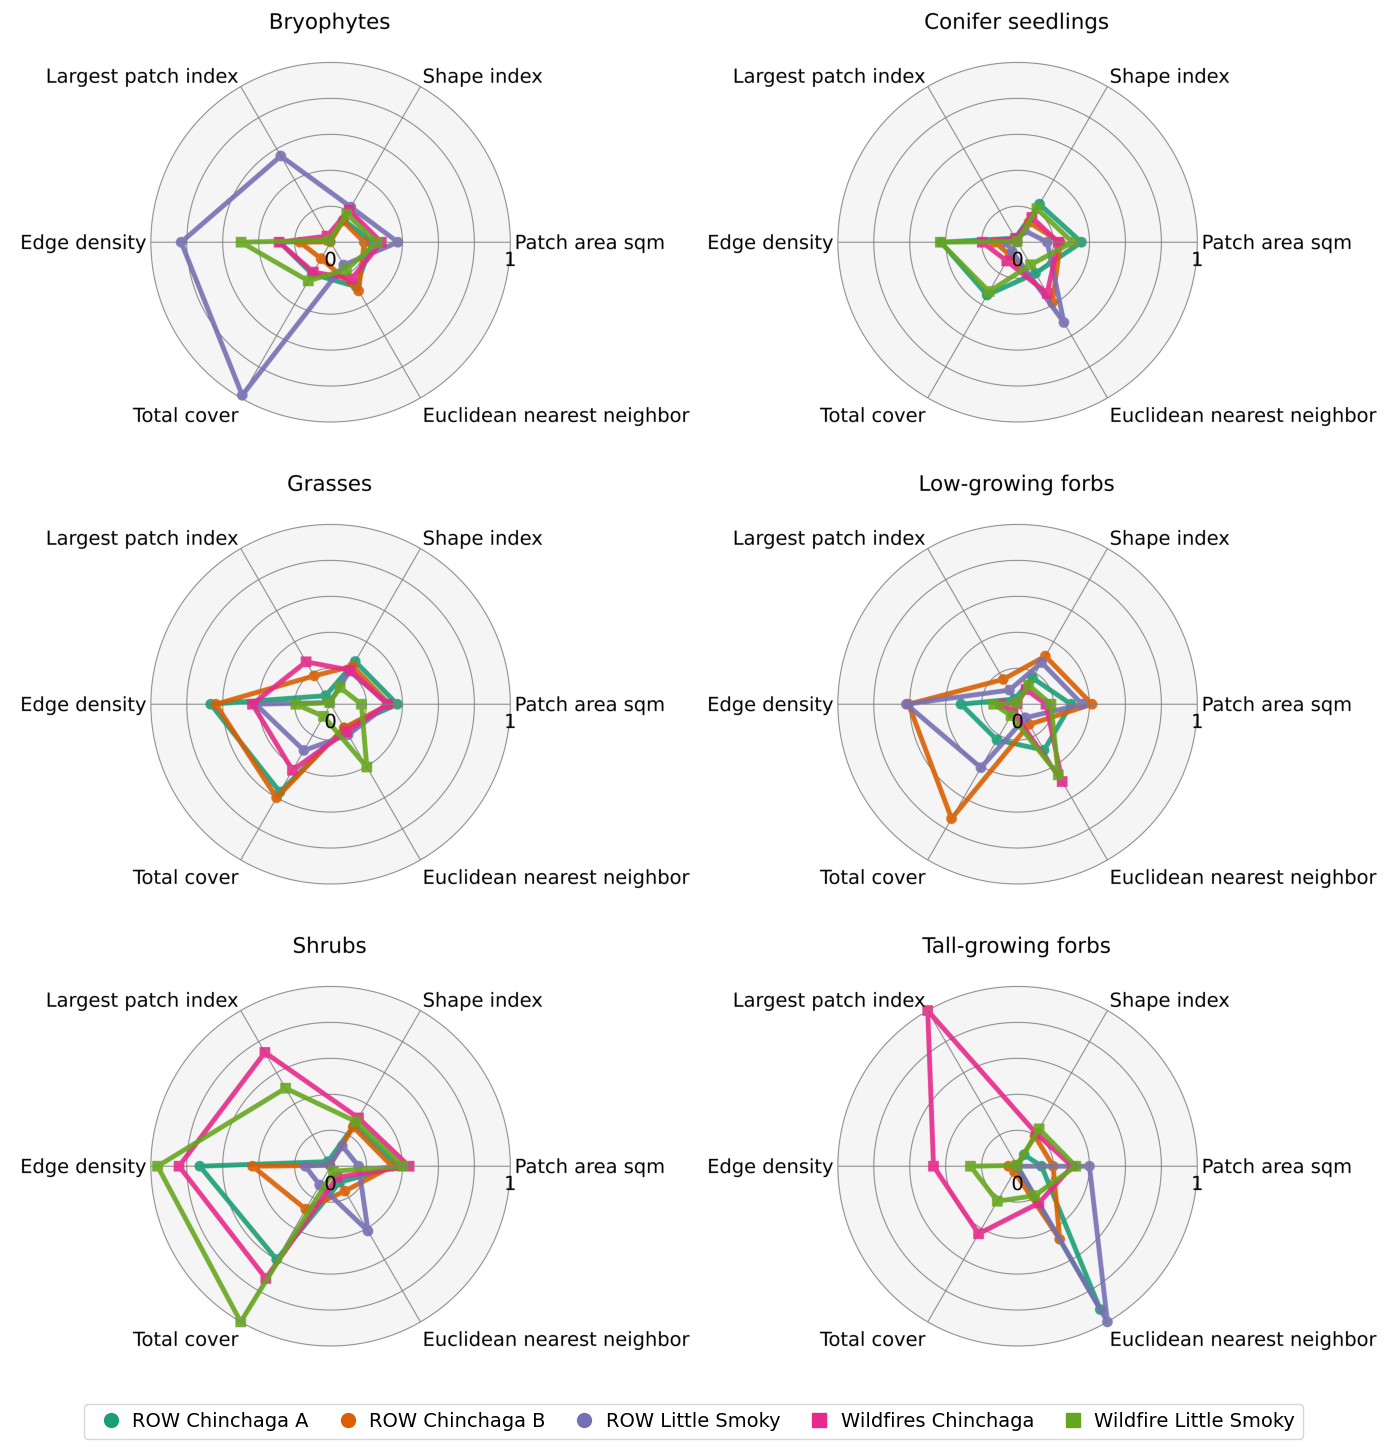

In [2]:
import matplotlib.pyplot as plt

font_size_c = 14 # used after individual plots are created and saved

# Assuming 'files' contains the paths to the images
files_1 = ['figures/Bryophytes.png', 'figures/Conifer seedlings.png', 'figures/Grasses.png', 'figures/Low-growing forbs.png',
           'figures/Shrubs.png', 'figures/Tall-growing forbs.png']

# Set up the subplot grid
fig, axs = plt.subplots(3, 2, figsize=(14, 14))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, file in enumerate(files_1):
    # Read the image
    img = mpimg.imread(file)
    # Display the image
    axs[i].imshow(img)
    # Remove axis ticks
    axs[i].axis('off')

legend_handles = []
for site, color in color_palette.items():
    if site in ['ROW Chinchaga A', 'ROW Chinchaga B', 'ROW Little Smoky']:
        handle = mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                               markersize=10, label=site)
    else:
        handle = mlines.Line2D([], [], color=color, marker='s', linestyle='None',
                               markersize=10, label=site)
    legend_handles.append(handle)

# Add the custom legend outside the bottom of the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0), prop={'size': font_size_c},
           handletextpad=0.1,  # Reduce spacing between handles and labels
           columnspacing=1.0)  # Reduce spacing between columns

# Adjust layout
plt.tight_layout()
# Save the plot
# plt.savefig('figures/Radar_plots_VegType.jpg', dpi=1200, bbox_inches="tight")

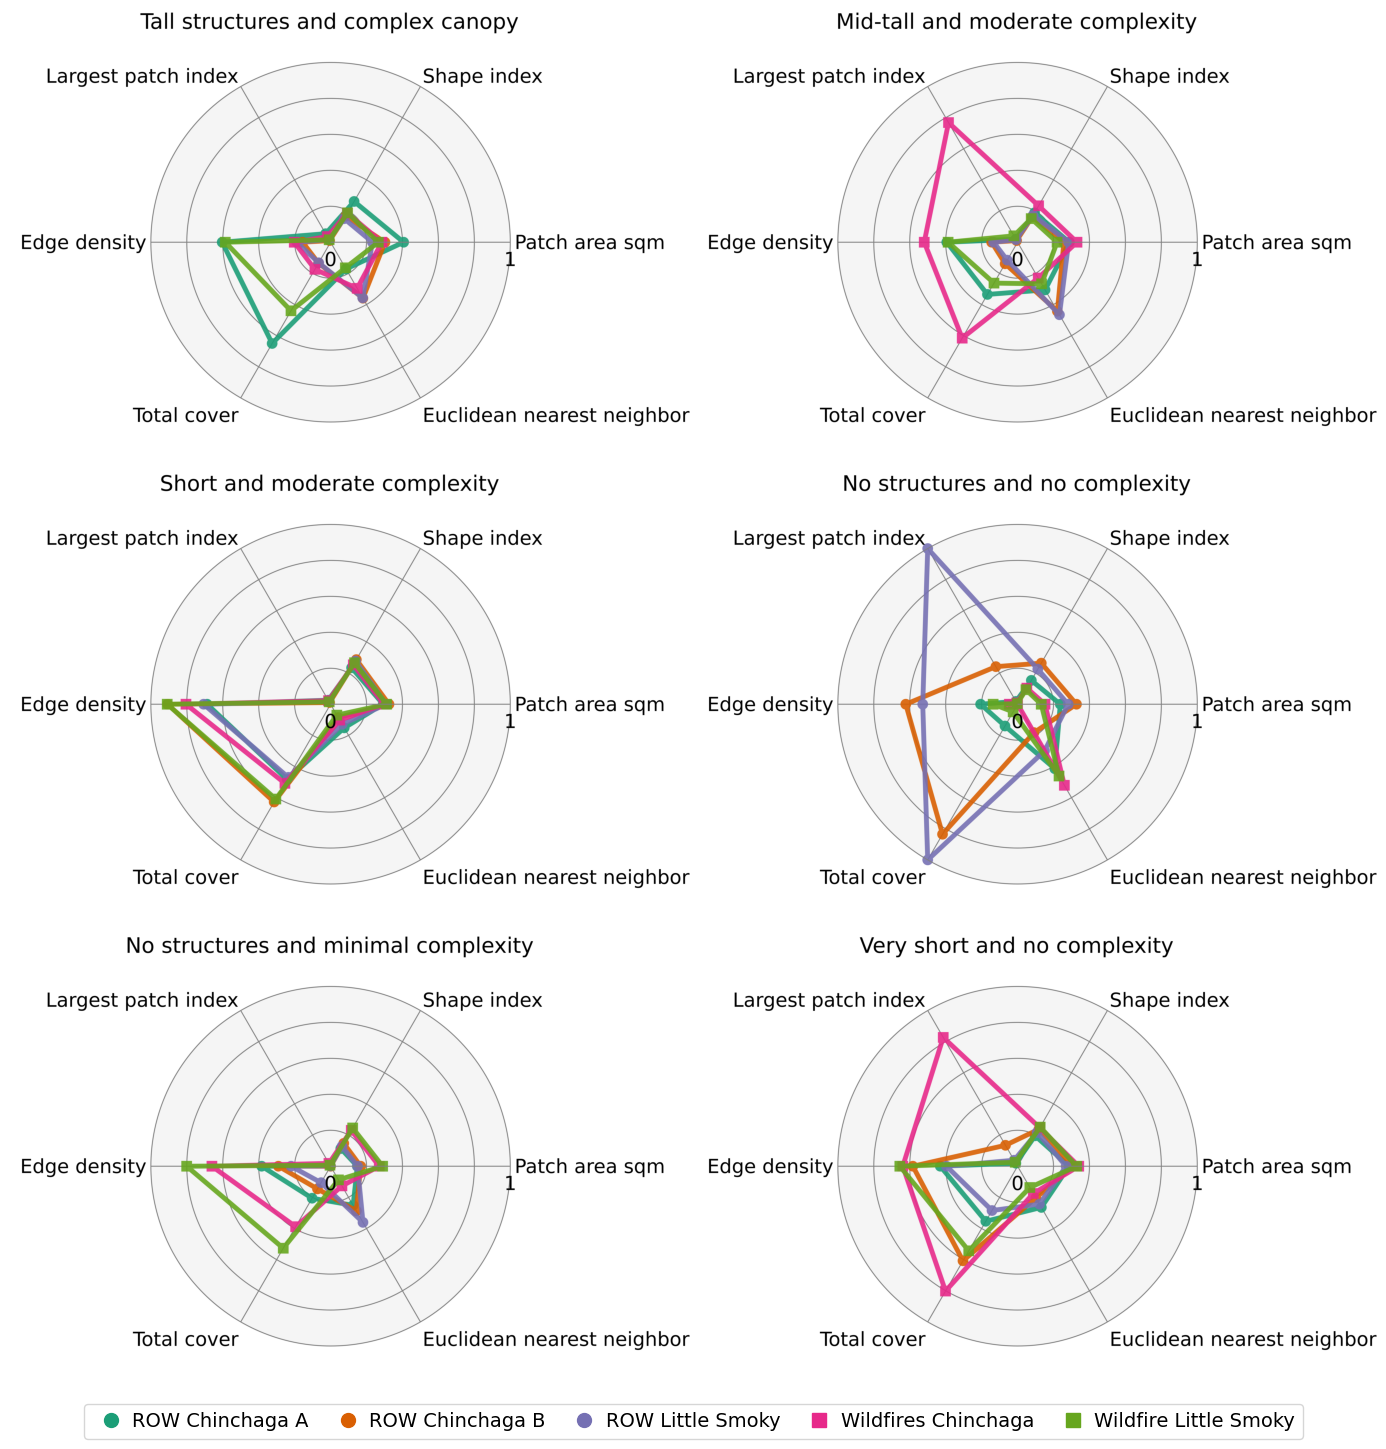

In [3]:
font_size_c = 14 # used after individual plots are created and saved

# Assuming 'files' contains the paths to the images
files_2 = ['figures/Tall structures and complex canopy.png',
         'figures/Mid-tall and moderate complexity.png',
         'figures/Short and moderate complexity.png',
         'figures/No structures and no complexity.png',
         'figures/No structures and minimal complexity.png',
         'figures/Very short and no complexity.png']

# Set up the subplot grid
fig, axs = plt.subplots(3, 2, figsize=(14, 14))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, file in enumerate(files_2):
    # Read the image
    img = mpimg.imread(file)
    # Display the image
    axs[i].imshow(img)
    # Remove axis ticks
    axs[i].axis('off')

legend_handles = []
for site, color in color_palette.items():
    if site in ['ROW Chinchaga A', 'ROW Chinchaga B', 'ROW Little Smoky']:
        handle = mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                               markersize=10, label=site)
    else:
        handle = mlines.Line2D([], [], color=color, marker='s', linestyle='None',
                               markersize=10, label=site)
    legend_handles.append(handle)

# Add the custom legend outside the bottom of the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0), prop={'size': font_size_c},
           handletextpad=0.1,  # Reduce spacing between handles and labels
           columnspacing=1.0)  # Reduce spacing between columns

# Adjust layout
plt.tight_layout()
# Show the plot
# plt.savefig('figures/Radar_plots_Structure.jpg', dpi=1200, bbox_inches="tight")